A continuación se muestra una matriz de expresión genética:

In [1]:
genexp<-read.csv("practica/GEMatrixFiltered.csv")
head(genexp)

X,X212284_x_at,X212869_x_at,X213614_x_at,X212391_x_at,X201257_x_at,AFFX.hum_alu_at,X206559_x_at,X214003_x_at,X208755_x_at,⋯,X214981_at,X216660_at,X217101_at,X218922_s_at,X203953_s_at,X221755_at,X208278_s_at,X207162_s_at,X206824_at,X218840_s_at
Normal.BC0043N,9167.03,7380.27,8341.82,7944.99,8367.28,7884.22,6209.89,6009.60,9017.07,⋯,13.9187,30.9902,26.8305,30.6226,13.6677,23.7455,29.1401,23.8904,64.3171,25.5825
Cancer.BC0043T,10635.90,11010.80,9859.02,10493.60,10805.70,8507.10,9060.41,9426.21,8674.11,⋯,17.2673,56.3875,16.9442,14.5954,15.2555,19.2764,16.4308,26.5672,53.7115,28.7201
Normal.BC0051N,8015.29,6112.62,8287.92,7360.60,7060.93,8003.40,7140.51,6029.11,7026.17,⋯,26.6429,29.1446,23.8505,32.2064,15.9346,27.4183,21.6383,21.3962,27.9609,45.1721
Cancer.BC0051T,9081.20,8925.35,8276.54,9021.02,8622.68,8925.17,7862.39,6847.31,9651.01,⋯,37.5716,30.0083,20.7826,22.1020,27.5567,26.4899,26.3171,16.6457,41.5037,25.8667
Normal.BC0057N,9006.52,8338.44,7069.53,7909.77,7348.80,7966.06,7120.25,7903.76,7387.18,⋯,36.4167,29.9436,45.3716,31.1614,31.3397,32.0059,29.1746,21.2647,34.7236,35.4706
Cancer.BC0057T,8307.87,7295.69,7048.75,7111.87,6372.62,8056.31,6406.97,6256.54,7098.11,⋯,21.3444,54.1291,37.4840,22.2405,50.9866,26.8458,33.2448,18.3316,24.6310,24.8679


In [2]:
ncol(genexp)
nrow(genexp)


[1] 482

[1] 86

### Limpieza de datos:

* Normalizar
* ¿Existen outliers? Tratamiento de Outliers

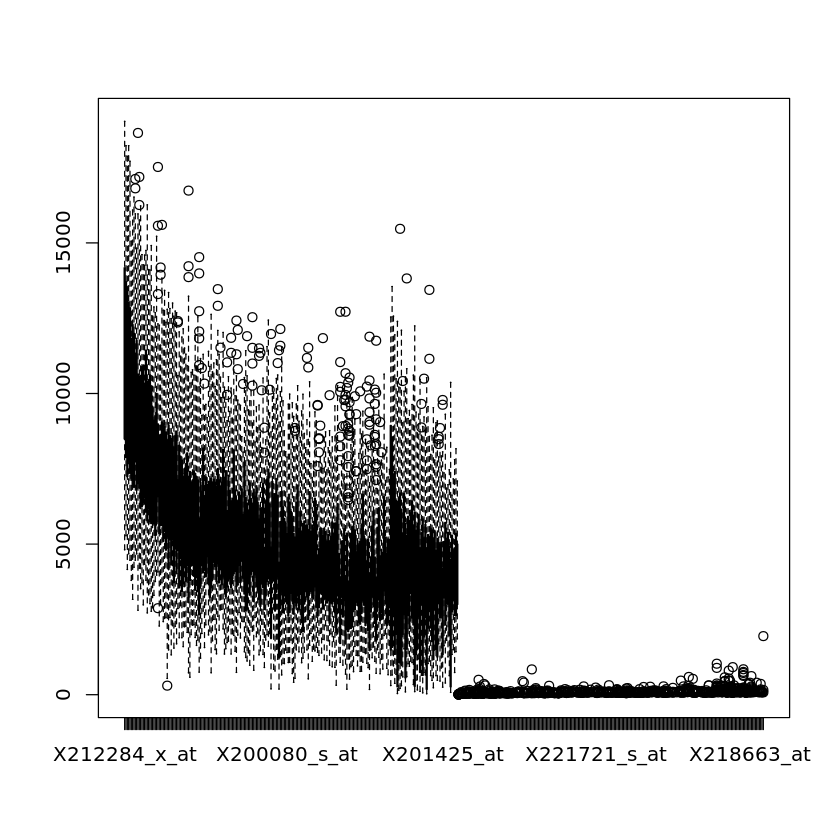

In [3]:
# Representamos los valores
boxplot(genexp[2:ncol(genexp)])

In [4]:
# Normalizamos
for (i in 2:ncol(genexp)) {
    mn <- mean(genexp[,i], na.rm = T)
    sd <- sd(genexp[,i], na.rm = T)
    
    genexp[,i] <- (genexp[,i] - mn) / sd
}

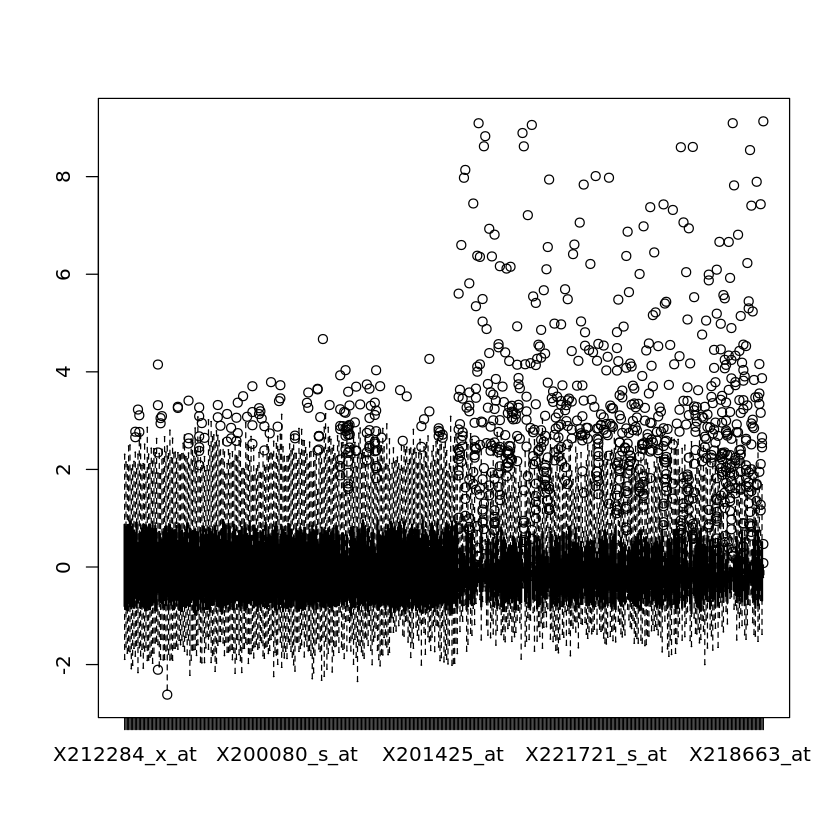

In [5]:
# Vemos como quedan ahora representados, tras la normalizacion
boxplot(genexp[2:ncol(genexp)])

In [6]:
# Tratamiento de Outliers
for (i in 2:ncol(genexp)){
    x <- genexp[,i]
    qnt  <- quantile(x, probs=c(.25, .75), na.rm = T)
    caps <- quantile(x, probs=c(.1, .90), na.rm = T)    
    H <- 10 * IQR(x, na.rm = T)
    x[x < (qnt[1] - H)] <- caps[1]
    x[x > (qnt[2] + H)] <- caps[2]
    genexp[,i]<-x
}

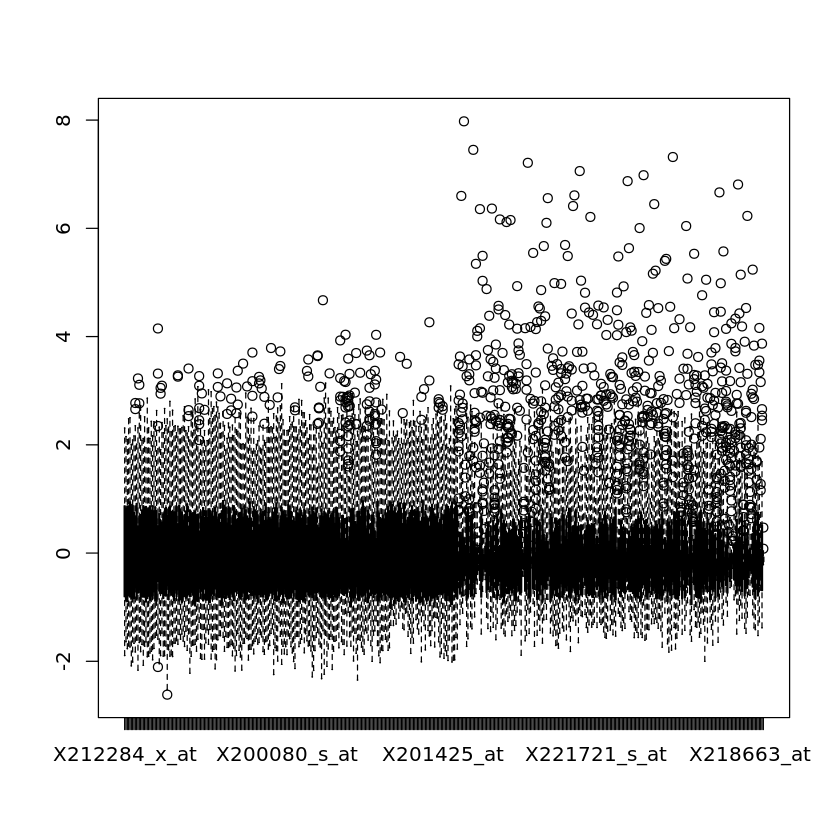

In [7]:
# Representamos tras tratamiento de Outliers
boxplot(genexp[2:ncol(genexp)])

### Parte 1
Realizar un modelo de regresión logistica que sea capaz de, dada la expresión genética de 482 genes realice una predicción de si el tejido es canceroso o no:
* Pintar curva ROC
* Para un umbral de 0 calcular:
 * Precisión
 * F0.5
 * Exactitud
 * Exhaustividad
 * Matriz de confusión
 

In [8]:
genexp1 <- genexp

In [9]:
# Quitamos el Id de Paciente y factorizamos
genexp1$X.n[grepl("Cancer", genexp1$X)] <- "Cancer"
genexp1$X.n[grepl("Normal", genexp1$X)] <- "Normal"
genexp1$X.f <- factor(genexp1$X.n, labels = c("Cancer", "Normal"))
genexp1$XF <- genexp1$X.f
genexp1$X.n <- NULL
genexp1$X.f <- NULL
genexp1$X <- NULL


# Determinamos Datos de Entrenamiento y Test
set.seed(1234)
itrain<-sample(1:nrow(genexp1),nrow(genexp1)*0.7)
genexp1.train<-genexp1[itrain,]
genexp1.test<-genexp1[-itrain,]

# Generamos el modelo con datos de Entrenamiento (al tener pocos datos habra overfitting)
model_genexp1 <- glm(data = genexp1.train, formula = XF~., family=binomial(link="logit"))

# Predecimos los datos de Test
y_predict <- predict(model_genexp1, genexp1.test)

# Matriz de Confusion
y_factor <- as.factor(ifelse(y_predict < 0, "Cancer", "Normal"))
table(y_factor, genexp1.test$XF)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

        
y_factor Cancer Normal
  Cancer      9      3
  Normal      4     10

In [10]:
M<-matrix(rep(0, 4),ncol = 2)
y_est=factor(ifelse(predict(model_genexp1,genexp1.test)< 0 ,1, 2),labels=c("Cancer","Normal"))

idx_Cancer <-genexp1.test$XF=="Cancer"
idx_Normal <-genexp1.test$XF=="Normal"


M[1,1]=sum(y_est[idx_Cancer]=="Cancer")
M[1,2]=sum(y_est[idx_Normal]=="Cancer")
M[2,1]=sum(y_est[idx_Cancer]=="Normal")
M[2,2]=sum(y_est[idx_Normal]=="Normal")
paste("Matriz de confusion: ")
M

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

[1] "Matriz de confusion: "

9,3
4,10


In [11]:
paste("Precision:", M[1,1]/(M[1,2]+M[1,1]))
paste("Exhausitivad:", M[1,1]/(M[2,1]+M[1,1]))
paste("Exactitud:",(M[1,1]+M[2,2])/sum(sum(M)))
p<-M[1,1]/(M[1,2]+M[1,1])
e<-M[1,1]/(M[2,1]+M[1,1])
b<-0.5
paste("Valor-F: ", (1+b^2)*(p*e)/(b^2*p+e))

[1] "Precision: 0.75"

[1] "Exhausitivad: 0.692307692307692"

[1] "Exactitud: 0.730769230769231"

[1] "Valor-F:  0.737704918032787"

Warning message:
“Removed 1 rows containing missing values (geom_path).”

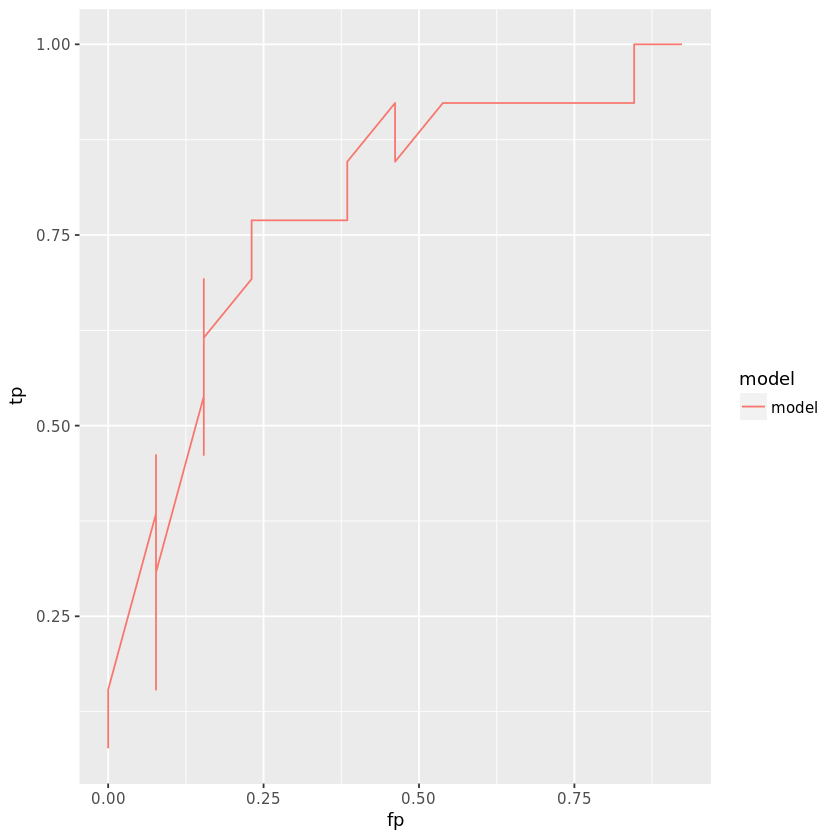

In [12]:
# Curva ROC
library(ggplot2)
calctp_fp<-function(y_predict, y_real, th){
    y_est <- ifelse(y_predict < th, "Cancer", "Normal")

    M <- table(y_est, y_real)
    if (ncol(M)==2 && nrow(M)==2){
        truePositive <- M[1,1] / (M[1,1]+M[2,1])
        falsePositive <- M[1,2] / (M[1,2]+M[2,2])
        c(tp=truePositive, fp=falsePositive)
    }else{
        c(tp=NA,fp=NA)
    }
}

# model <- glm(data=genexp1.train, formula=XF~., family = binomial(link='logit'))
# y_predict <- predict(model, genexp1.test)
# dfROC <- data.frame(th=unique(y_predict), tp=NA, fp=NA, model="model")
dfROC <- data.frame(th=unique(y_predict), tp=NA, fp=NA, model="model")

for (i in 1:nrow(dfROC)){
    v <- calctp_fp(y_predict, genexp1.test$XF, dfROC$th[i])
    dfROC$tp[i] <- v["tp"]
    dfROC$fp[i] <- v["fp"]
}

dfROC <- dfROC[order(dfROC$fp),]

ggplot(data=dfROC, aes(x=fp,y=tp,color=model)) + geom_path()

### Parte 2

Realizar clusterización por k-means y uno basado en áboles (dendrograma). ¿Cual sería el número de clusters óptimo?  ¿Puedes identificar algún cluster interesante?

In [13]:
genexp2 <- genexp1
genexp2$XF <- NULL

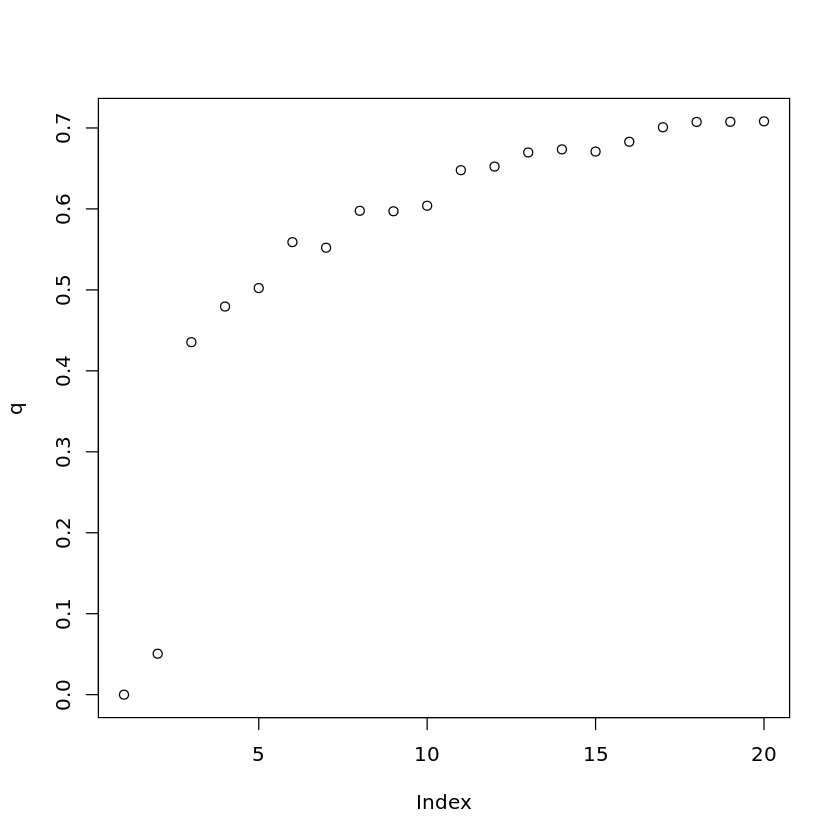

In [14]:
# Determinar el número de clusteres óptimo
q <- c()
for (k in 1:20){
    myclust <- kmeans(genexp2, k)
    q[k] <- myclust$betweenss/myclust$totss
}
plot(q)

In [15]:
# Si generamos 5 clusteres
myclust <- kmeans(genexp2, 5)
table(genexp1$XF, myclust$cluster)

        
          1  2  3  4  5
  Cancer 16  1 18  2  6
  Normal  1  2  8 21 11

In [16]:
# Si Generamos 4 clusteres
myclust <- kmeans(genexp2, 4)
table(genexp1$XF, myclust$cluster)

        
          1  2  3  4
  Cancer 16  1  2 24
  Normal  1  2 21 19

In [17]:
# Generamos 3 clusteres (optimo)
myclust <- kmeans(genexp2, 3)
table(genexp1$XF, myclust$cluster)

        
          1  2  3
  Cancer 18  6 19
  Normal  9 11 23

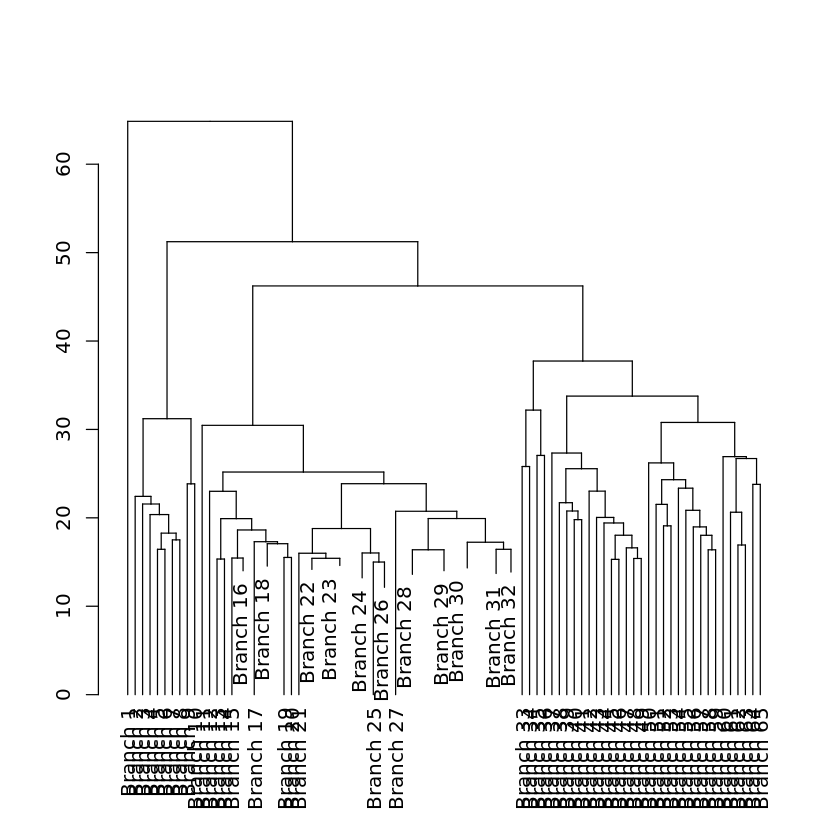

In [18]:
# Ahora generamos el dedrograma
d <- dist(as.matrix(genexp2), method = "euclidean")
hc <- hclust(d, method = "complete")
hcd <- as.dendrogram(hc)
plot(cut(hcd, h = 15)$upper)

### Parte 3

Realizar un PCA, quedarse con los dos valores más representativos. Pintarlo en una nube de puntos donde los tejidos normales tendrán un color y los tejidos con cancer otro.

A partir de esta representación simplificada (con solo 2 valores más significativos) crear un modelo de regresión logística. Compara la curva ROC de este nuevo modelo con el de la *Parte 1*

In [19]:
genexp3 <- genexp2

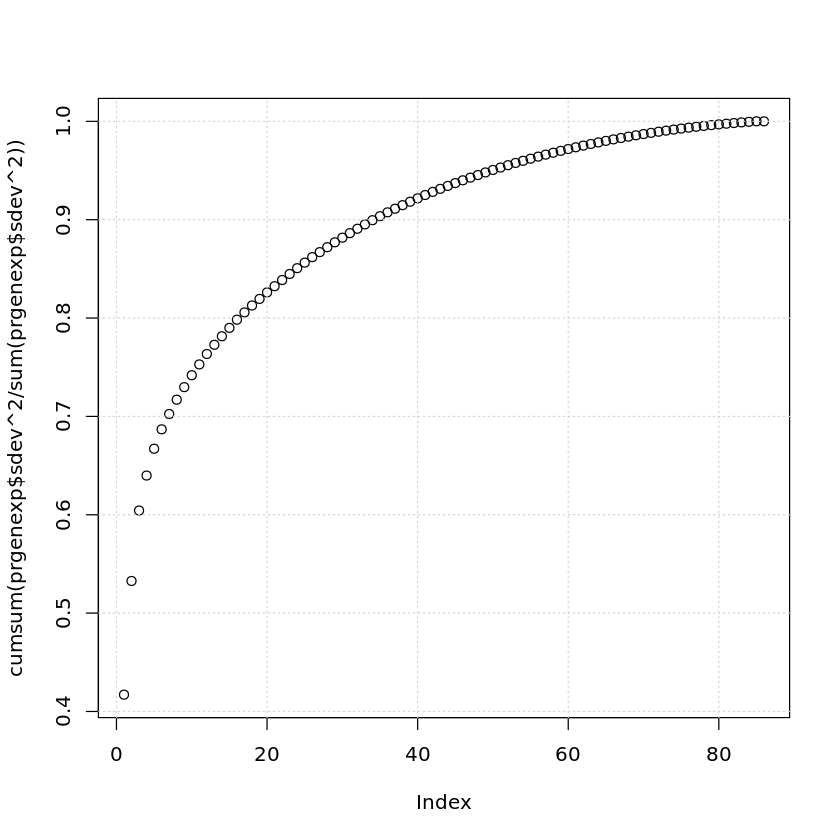

In [20]:
# Calculamos PCA
prgenexp <- prcomp(genexp3, center = TRUE, scale. = TRUE)
plot(cumsum(prgenexp$sdev^2 / sum(prgenexp$sdev^2)))
grid()

In [21]:
# Nos quedamos con los 3 primeros valores, que llegan a mas del 60% de la varianza
set.seed(1234)
pca_data <- as.data.frame(prgenexp$x[,1:3])
pca_data$XF <- genexp1$XF

idx <- sample(1:nrow(pca_data), nrow(pca_data) * 0.7)
genexp1.train_norm <- pca_data[idx,]
genexp1.test_norm <- pca_data[-idx,]

model_pca <- glm(data = genexp1.train_norm, formula = XF~., family = binomial(link="logit"))

y_predict_pca <- predict(model_pca, genexp1.test_norm)
y_factor_pca <- as.factor(ifelse(y_predict < 0, "Cancer", "Normal"))

table(y_factor_pca, genexp1.test_norm$XF)

            
y_factor_pca Cancer Normal
      Cancer      9      3
      Normal      4     10

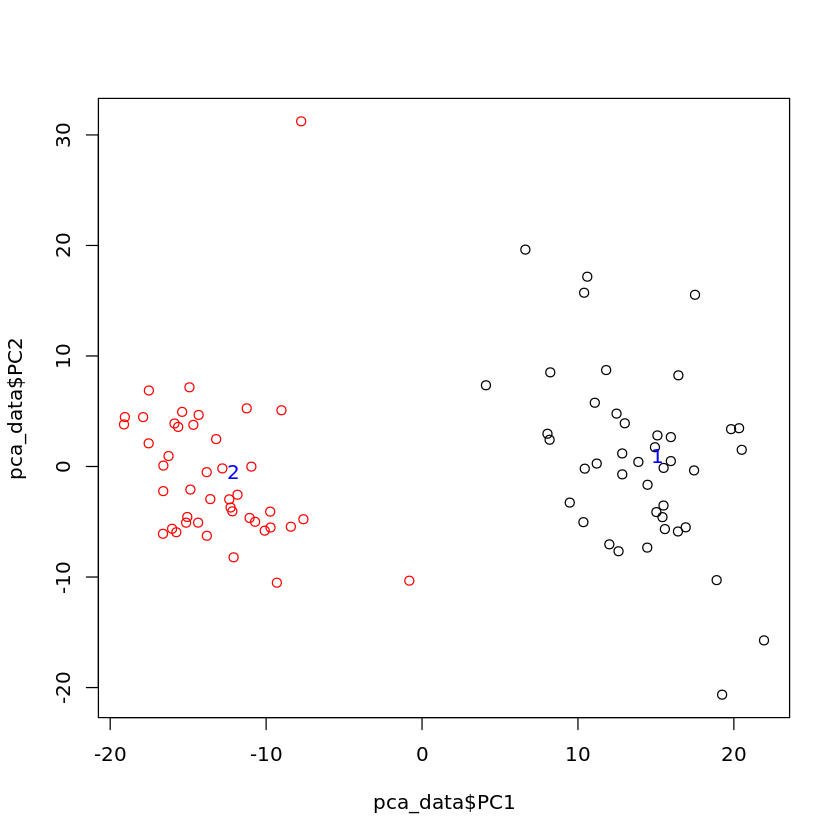

In [22]:
# Nube de puntos de PCA
myclust_pca <- kmeans(pca_data[,1:2],2)
plot(pca_data$PC1, pca_data$PC2, col = myclust_pca$cluster)
    text(x = myclust_pca$centers[,1], y = myclust_pca$centers[,2], cex=1, pos=4, labels=(1:nrow(myclust_pca$centers)),col="blue")

Warning message:
“Removed 2 rows containing missing values (geom_path).”

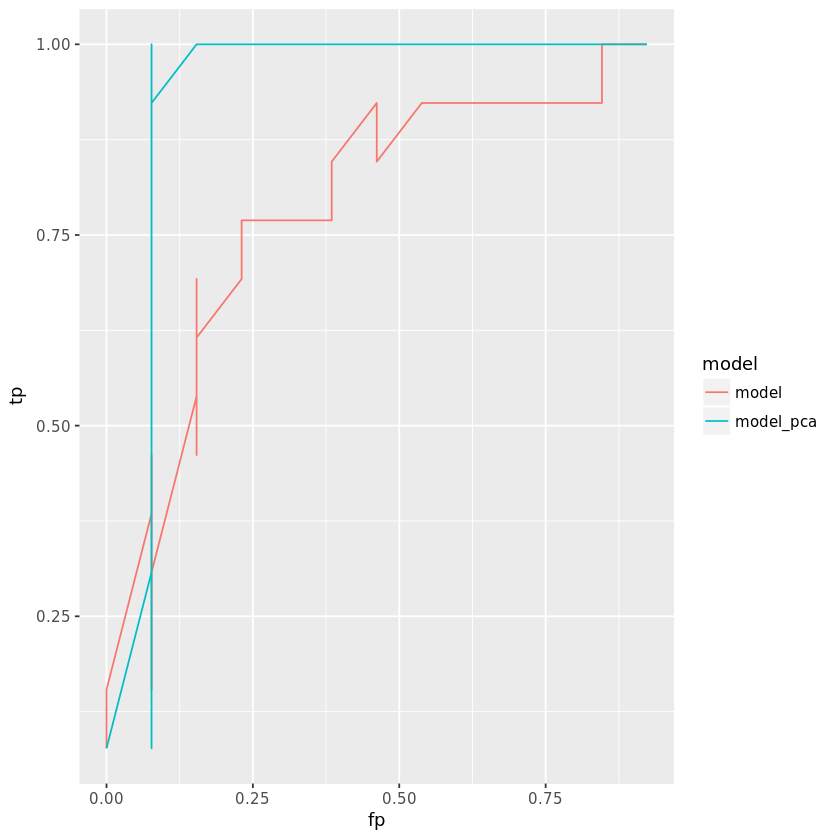

In [23]:
# Curva ROC de la Parte 1 vs PCA
calctp_fp<-function(y_predict, y_real, th){
    y_est <- ifelse(y_predict < th, "Cancer", "Normal")

    M <- table(y_est, y_real)
    if (ncol(M)==2 && nrow(M)==2){
        truePositive <- M[1,1] / (M[1,1]+M[2,1])
        falsePositive <- M[1,2] / (M[1,2]+M[2,2])
        c(tp=truePositive, fp=falsePositive)
    }else{
        c(tp=NA,fp=NA)
    }
}


# Parte 1
dfROC <- data.frame(th=unique(y_predict), tp=NA, fp=NA, model="model")
for (i in 1:nrow(dfROC)){
    v <- calctp_fp(y_predict, genexp1.test$XF, dfROC$th[i])
    dfROC$tp[i] <- v["tp"]
    dfROC$fp[i] <- v["fp"]
}

# PCA
dfROC_pca <- data.frame(th=unique(y_predict_pca), tp=NA, fp=NA, model="model_pca")
for (i in 1:nrow(dfROC_pca)){
    v <- calctp_fp(y_predict_pca, genexp1.test_norm$XF, dfROC_pca$th[i])
    dfROC_pca$tp[i] <- v["tp"]
    dfROC_pca$fp[i] <- v["fp"]
}

dfROC <- rbind(dfROC, dfROC_pca)
dfROC <- dfROC[order(dfROC$fp),]

ggplot(data=dfROC, aes(x=fp,y=tp,color=model)) + geom_path()